In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.animation as animation

from collections import OrderedDict

In [2]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = [3, 20, 20, 20, 20, 20, 20, 2] 
        self.depth = len(self.layers) - 1

        self.activation = nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(self.layers[i], self.layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(('layer_%d' % (self.depth - 1), nn.Linear(self.layers[-2], self.layers[-1])))

        layerDict = OrderedDict(layer_list)
        self.model = nn.Sequential(layerDict)

    def forward(self, x):
        out = self.model(x)
        return out

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nu = 0.01/np.pi

loss_history = []
loss_history_u = []
loss_history_v = []
loss_history_f = []
loss_history_g = []
loss_history_h = []

class NS:
    def __init__(self, X, Y, T, u, v):
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True).to(device)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True).to(device)

        self.u = torch.tensor(u, dtype=torch.float32).to(device)
        self.v = torch.tensor(v, dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x.shape[0], 1)).to(device)
        
        self.net = DNN().to(device)

        # lr=1 --> lr=0.05
        self.LBFGS = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000, 
                                           history_size=50, tolerance_grad=1e-5, tolerance_change=0.5 * np.finfo(float).eps, line_search_fn="strong_wolfe")
        
        self.Adam = torch.optim.Adam(self.net.parameters(), lr=0.05)

        self.optimizer=self.LBFGS

        self.mse = nn.MSELoss().to(device)

        self.ls = 0
        self.iter = 0

    def function(self, x, y, t):
        res = self.net(torch.hstack((x, y, t)))
        u, v = res[:, 0:1], res[:, 1:2]

        # u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), 
        #                         create_graph=True)[0]
        # v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), 
        #                             create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), 
                                   create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), 
                                   create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), 
                                   create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), 
                                   create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]

        # p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), 
        #                           create_graph=True)[0]
        # p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), 
        #                           create_graph=True)[0]

        # Burgers Equations
        f = u_t + u * u_x + v * u_y - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y - nu * (v_xx + v_yy)
        h = u_x + v_y

        # Navier-Stokes equations
        # f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        # g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

        return u, v, f, g, h
    
    def closure(self):
        self.optimizer.zero_grad()

        # start the training process with a few iterations of Adam, then switch to LBFGS
        # if self.iter == 10:
        #     self.optimizer = self.LBFGS
        #     print(r'Changed optimizer')

        # u_pred, v_pred, p_pred, f_pred, g_pred = self.function(self.x, self.y, self.t)

        u_pred, v_pred, f_pred, g_pred, h_pred = self.function(self.x, self.y, self.t)

        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        f_loss = self.mse(f_pred, self.null)
        g_loss = self.mse(g_pred, self.null)
        h_loss = self.mse(h_pred, self.null)

        self.ls = u_loss + v_loss + f_loss + g_loss + h_loss

        loss_history_u.append(u_loss.detach().cpu().numpy())
        loss_history_v.append(v_loss.detach().cpu().numpy())
        loss_history_f.append(f_loss.detach().cpu().numpy())
        loss_history_g.append(g_loss.detach().cpu().numpy())
        loss_history_h.append(h_loss.detach().cpu().numpy())

        loss_history.append(self.ls.detach().cpu().numpy())

        self.ls.backward()

        self.iter += 1
        if not self.iter % 1: 
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls
    

    def train(self):
        self.net.train()
        self.optimizer.step(self.closure)


### Attempt with Burger's data

In [4]:
N_train = 5000

data = scipy.io.loadmat('C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\new_2d_burger_data.mat')

x = data['x'].flatten().reshape(-1, 1) #  sqrt(N) x 1
y = data['y'].flatten().reshape(-1, 1) # sqrt(N) x 1
t_star = data['t'].flatten().reshape(-1, 1) # T x 1
X, Y = np.meshgrid(x, y) 
X_star = np.stack((X.ravel(), Y.ravel()), axis=1) # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

usol = np.real(data['usol']).reshape(N, T) # N x T
vsol = np.real(data['vsol']).reshape(N, T) # N x T

x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

# Rearranging data
XX = np.tile(X_star[:, 0:1], (1, T)) # N x T
YY = np.tile(X_star[:, 1:2], (1, T)) # N x T
TT = np.tile(t_star, (1, N)).T # N x T

x = XX.flatten()[:, None] # NT x 1
y = YY.flatten()[:, None] # NT x 1
t = TT.flatten()[:, None] # NT x 1

u = usol.flatten()[:, None] # NT x 1
v = vsol.flatten()[:, None] # NT x 1

idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]


In [5]:
model = NS(x_train, y_train, t_train, u_train, v_train)
model.train()

Iteration: 1, Loss: 0.564378
Iteration: 2, Loss: 0.472121
Iteration: 3, Loss: 0.318558
Iteration: 4, Loss: 0.314482
Iteration: 5, Loss: 0.314329
Iteration: 6, Loss: 0.314318
Iteration: 7, Loss: 0.314228
Iteration: 8, Loss: 0.314152
Iteration: 9, Loss: 0.314066
Iteration: 10, Loss: 0.314033
Iteration: 11, Loss: 0.314009
Iteration: 12, Loss: 0.313923
Iteration: 13, Loss: 0.313743
Iteration: 14, Loss: 0.313510
Iteration: 15, Loss: 0.313065
Iteration: 16, Loss: 0.312434
Iteration: 17, Loss: 0.312376
Iteration: 18, Loss: 0.312323
Iteration: 19, Loss: 0.312251
Iteration: 20, Loss: 0.312072
Iteration: 21, Loss: 0.311906
Iteration: 22, Loss: 0.311223
Iteration: 23, Loss: 0.310122
Iteration: 24, Loss: 0.343934
Iteration: 25, Loss: 0.309182
Iteration: 26, Loss: 0.307846
Iteration: 27, Loss: 0.304706
Iteration: 28, Loss: 0.383538
Iteration: 29, Loss: 0.303690
Iteration: 30, Loss: 0.302961
Iteration: 31, Loss: 0.302480
Iteration: 32, Loss: 0.301905
Iteration: 33, Loss: 0.300044
Iteration: 34, Loss

In [6]:
x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)

In [7]:
u_out, v_out, f_out, g_out, h_out= model.function(x_test, y_test, t_test)

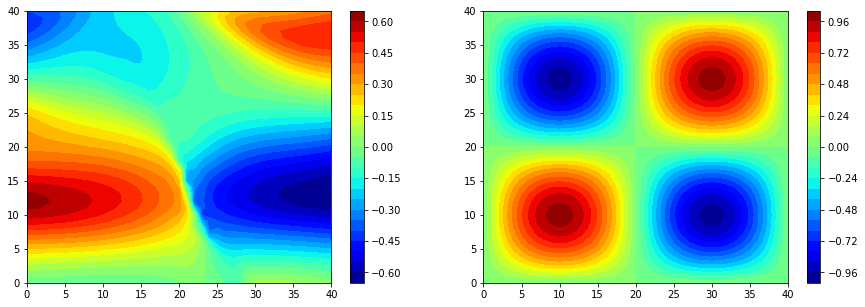

MovieWriter ffmpeg unavailable; using Pillow instead.


In [16]:
u_plot = u_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (41, 41))
usol = np.reshape(usol, (41, 41, 100))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

h = ax1.contourf(u_plot, levels=30, cmap='jet')
fig.colorbar(h)

h = ax2.contourf(usol[:, :, 0], levels=30, cmap='jet')
fig.colorbar(h)
plt.show()

def animate(i):
    ax1.clear()
    ax2.clear()
    u_out, v_out, f_out, g_out, h_out = model.function(x_test, y_test, i*t_test)
    u_plot = u_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (41, 41))
    cax = ax1.contourf(u_plot, levels=20, cmap='jet')
    cax = ax2.contourf(usol[:, :, i], levels=20, cmap='jet')
    ax1.set_xlabel(r'$x')
    ax1.set_ylabel(r'$y$')
    ax2.set_xlabel(r'$x')
    ax2.set_ylabel(r'$y$')
    ax1.set_title(r'Predicted $u(x, \; y, \;t)$')
    ax2.set_title(r'Ground truth $u(x, \;y, \;t)$')

ani = animation.FuncAnimation(fig, animate, 50, interval=1, blit=False)
ani.save('u_field_2d_burgers.gif')
plt.show()
    

<ipython-input-9-437c684137b6>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
MovieWriter ffmpeg unavailable; using Pillow instead.


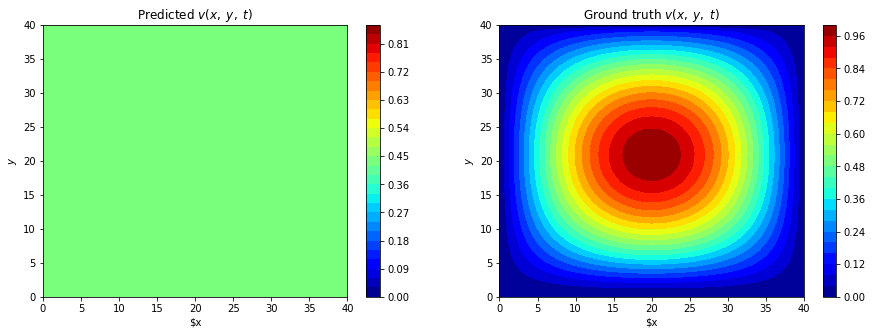

In [9]:
v_plot = v_out.data.cpu().numpy()
v_plot = np.reshape(v_plot, (41, 41))
vsol = np.reshape(vsol, (41, 41, 100))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

h = ax1.contourf(v_plot, levels=30, cmap='jet')
fig.colorbar(h)

h = ax2.contourf(vsol[:, :, 1], levels=30, cmap='jet')
fig.colorbar(h)
plt.show()

def animate(i):
    ax1.clear()
    ax2.clear()
    u_out, v_out, f_out, g_out, h_out = model.function(x_test, y_test, i*t_test)
    v_plot = v_out.data.cpu().numpy()
    v_plot = np.reshape(v_plot, (41, 41))
    cax = ax1.contourf(v_plot, levels=20, cmap='jet')
    cax = ax2.contourf(vsol[:, :, i], levels=20, cmap='jet')
    ax1.set_xlabel(r'$x')
    ax1.set_ylabel(r'$y$')
    ax2.set_xlabel(r'$x')
    ax2.set_ylabel(r'$y$')
    ax1.set_title(r'Predicted $v(x, \; y, \;t)$')
    ax2.set_title(r'Ground truth $v(x, \;y, \;t)$')

ani = animation.FuncAnimation(fig, animate, 50, interval=1, blit=False)
ani.save('v_field_2d_burgers.gif')
plt.show()
    

Text(0, 0.5, 'Loss')

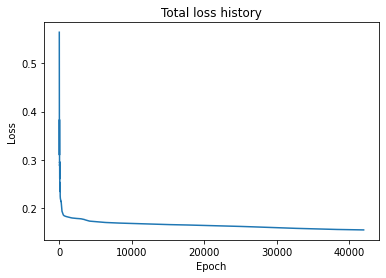

In [13]:
plt.plot(loss_history)
plt.title('Total loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Loss history v')

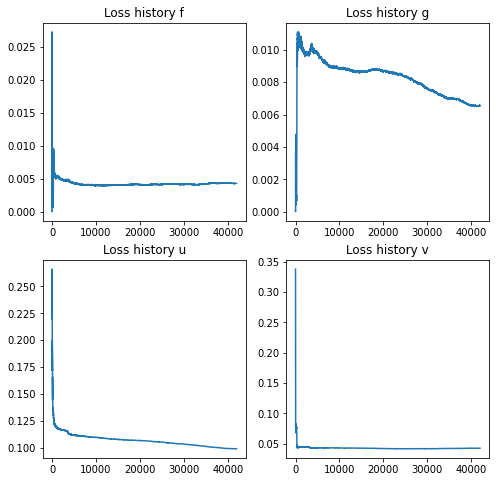

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

ax1.plot(loss_history_f)
ax1.set_title('Loss history f')
ax2.plot(loss_history_g)
ax2.set_title('Loss history g')
ax3.plot(loss_history_u)
ax3.set_title('Loss history u')
ax4.plot(loss_history_v)
ax4.set_title('Loss history v')


Text(0, 0.5, 'Loss')

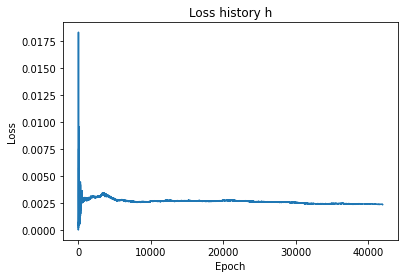

In [15]:
plt.plot(loss_history_h)
plt.title('Loss history h')
plt.xlabel('Epoch')
plt.ylabel('Loss')